<a href="https://colab.research.google.com/github/ryu0315360/Testing/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO
1. Optimization
2. Data augmentation
3. Visualization (epoch-accuracy plot, loss plot, heatmap...)

# library

In [ ]:
!pip install keras.utils

In [ ]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew

import json
import tensorflow as tf
from matplotlib.pyplot import specgram

import IPython.display as ipd  # To play sound in the notebook

In [ ]:
import pandas as pd
import librosa
import librosa.display
import soundfile
import os, glob, pickle, sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
## path!

from google.colab import drive
drive.mount('/content/gdrive')

path = 'gdrive/MyDrive/Data/Actor_*/*.wav' 
path_2 = 'gdrive/MyDrive/Data/Actor_02/*.wav' 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install pydub

In [ ]:
from pydub import AudioSegment

# extract features

In [ ]:
def extract_feature_all(file_name, mfcc, chroma, mel): # mel 1d (mean), mel&mfcc 1d

  with soundfile.SoundFile(file_name) as sound_file:
      X = sound_file.read(dtype="float32")
      sample_rate=sound_file.samplerate
      result=np.array([])
      if chroma:
          stft=np.abs(librosa.stft(X))
      if mfcc:
          mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
          result=np.hstack((result, mfccs))
      if chroma:
          chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
          result=np.hstack((result, chroma))
      if mel:
          mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
          result=np.hstack((result, mel))
          
  return result

In [ ]:
def extract_feature(file_name, feature, plot_mel): # 1d mfcc, 1d mel (flatten)
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    result=np.array([])

    if feature == 'mfcc':
      mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0) # mean...
      # temp = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc = 40)
      # librosa.display.specshow(temp)
      # plt.colorbar()
      # plt.show()
      # print("this is shape of temp: ", temp.shape) # (40, 200-300)
      # print("This is shape of mfccs: ", mfccs.shape) # (40, )
      result=np.hstack((result, mfccs))
    elif feature == 'mel':
      # mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0) # mean??
      mel = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128)
      # print("shape of mel: ", mel.shape)
      mel = mel.flatten()
      # print("shape of mel.flatten(): ", mel.shape) # (12---, )
      result=np.hstack((result, mel))
      # result = mel

      if plot_mel:
        # D = librosa.stft(X)  # STFT of X
        # S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        # fig, ax = plt.subplots()
        # img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
        # ax.set(title='Mel Spectrogram')
        # fig.colorbar(img, ax=ax, format="%+2.f dB")
        # plt.show()
        fig, ax = plt.subplots()
        mel_dB = librosa.power_to_db(mel, ref=np.max)
        img = librosa.display.specshow(mel_dB, x_axis='time', y_axis='mel', sr=sample_rate, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')
        print("mel_dB: ", mel_dB) 
        print("This is mel_dB.shape : ", mel_dB.shape) # (128, 300-400)


    return result

In [ ]:
def extract_mel2d(file_name, plot_mel = False): # mel 2d

  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    # SAMPLE_RATE = 22050
    result=np.array([])

    mel = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128)
    print("shape of mel: ", mel.shape)
    # result=np.hstack((result, mel))
    result = np.array(mel)
    result = np.expand_dims(result, axis=-1)
    print("shape of result : ", result.shape)

    if plot_mel:
      fig, ax = plt.subplots()
      mel_dB = librosa.power_to_db(mel, ref=np.max)
      img = librosa.display.specshow(mel_dB, x_axis='time', y_axis='mel', sr=sample_rate, ax=ax)
      fig.colorbar(img, ax=ax, format='%+2.0f dB')
      ax.set(title='Mel-frequency spectrogram')
      print("mel_dB: ", mel_dB) 
      print("This is mel_dB.shape : ", mel_dB.shape) # (128, 300-400)

  return result


In [ ]:
def extract_mfcc2d(file_name): # mfcc 2d
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    # SAMPLE_RATE = 22050
    result=np.array([])

    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc = 40)
    print("shape of mfcc: ", mfcc.shape) # (40, 282)
    # result=np.hstack((result, mel))
    result = np.array(mfcc)
    result = np.expand_dims(mfcc, axis=-1)
    print("shape of result : ", result.shape)
  
  return result

In [ ]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe
# observed_emotions=['calm', 'happy', 'fearful', 'disgust']

# load data (1440)

In [ ]:
## make all audio data duration 3 sec
## just run once. it exports all data to 3 sec long.

def padding_duration():
  for file in glob.glob(path):

    try:
      file_name=os.path.basename(file)
      # y, sr = librosa.load(file_name, offset=1.0, duration=3.0)
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
    except:
      print("Decoding error")
      continue

    pad_ms = 3000  # milliseconds of silence needed # 3sec

    print("before duration: ", sound.duration_seconds)

    if float(sound.duration_seconds) < float(3.0): 
      print("shorter than 3")
      temp = pad_ms - sound.duration_seconds*1000
      silence = AudioSegment.silent(duration= temp)
      # audio = AudioSegment.from_wav(file)
      sound = sound + silence  # Adding silence after the audio
      sound.export(file, format='wav')
    else:
      print("longer than 3")
      sound = sound[:pad_ms] 
      sound.export(file, format="wav")
    
    print("after duration: ", sound.duration_seconds)

    if sound.duration_seconds != 3.0:
      print("duration error")
      return 0

  return 0

padding_duration()

In [ ]:
# all features 1d (mean)
def load_data(test_size=0.2): # mel 1d (mean)
  x,y=[],[]
  for file in glob.glob(path):
    try:
      print(file)
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

      if sound.duration_seconds != 3.0:
        print("duration error!")
        continue

      emotion=emotions[file_name.split("-")[2]]
      # if emotion not in observed_emotions:
      #     continue
      feature=extract_feature_all(file, mfcc=False, chroma=False, mel=True)
      x.append(feature)
      y.append(emotion)

    except:
      print("decoding error")
      continue

  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
# mfcc 1d (mean)
def load_data_mfcc1d(test_size = 0.2, feature = 'mfcc', plot_mel = False):
  x,y=[],[]
  for file in glob.glob(path):
    try:
      # print(file)
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

      if sound.duration_seconds != 3.0:
        print("duration error!")
        continue

      emotion=emotions[file_name.split("-")[2]]
      features = extract_feature(file, feature = feature, plot_mel = plot_mel)
      # feature = extract_feature_all(file, mfcc= True, chroma = False, mel = True)
      x.append(features)
      y.append(emotion)
    except: # decoding error..
      print("decoding error")
      continue

  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
# mel 1d (flatten) 
def load_data_mel1d(test_size = 0.2, feature = 'mel', plot_mel = False):
  x,y=[],[]
  cnt = 1
  for file in glob.glob(path):
    try:
      file_name=os.path.basename(file)
      # y, sr = librosa.load(file_name, offset=1.0, duration=3.0)
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)

      if sound.duration_seconds != 3.0:
        print("duration error!")
        continue
      
      # print("{}th duration: {}".format(cnt, sound.duration_seconds))
      emotion=emotions[file_name.split("-")[2]]
      features = extract_feature(file, feature = feature, plot_mel = plot_mel) # file
      # feature = extract_feature_all(file, mfcc= True, chroma = False, mel = True)
      x.append(features)
      y.append(emotion)
      cnt += 1
    
    except:
      print("=============Error============")
      continue
    

  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)


In [ ]:
# mel 2d 
def load_data_mel2d(test_size = 0.2, plot_mel = False):
  # x = np.empty(shape = (128, 469, 1))
  x = np.array([])
  cnt = 0
  # x,y=[],[]
  y = []
  for file in glob.glob(path):
    try:
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

      if sound.duration_seconds != 3.0:
        print("duration error!")
        continue

      emotion=emotions[file_name.split("-")[2]]
      features = extract_mel2d(file, False)
      # cnt += 1

      if x.size == 0:
        features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
        x = features
      else:
        features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
        x = np.vstack((x, features))

      print("This is x.shape: ", x.shape)
      # print(x)
      y.append(emotion)
      # print("append success")
      
    except: # decoding error..
      print("decoding error")
      continue
    
  try:
    temp = np.array(x)  
    print("This is final np.array(x).shape: ", temp.shape)
  except:
    print("fail to np.array(x).shape")
    return x, y, x, y

  # return x, y
  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
# mfcc 2d 
def load_data_mfcc2d(test_size = 0.2):
  # x = np.empty(shape = (128, 469, 1))
  x = np.array([])
  cnt = 0
  y = []
  for file in glob.glob(path):
    try:
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

      if sound.duration_seconds != 3.0:
        print("duration error!")
        continue

      emotion=emotions[file_name.split("-")[2]]
      features = extract_mfcc2d(file)

      if x.size == 0:
        features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
        x = features
      else:
        features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
        x = np.vstack((x, features))

      print("This is x.shape: ", x.shape)
      y.append(emotion)
      
    except:
      print("decoding error")
      continue
    
  try:
    temp = np.array(x)  
    print("This is final np.array(x).shape: ", temp.shape)
  except:
    print("fail to np.array(x).shape")
    return x, y, x, y

  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

# train test load

In [ ]:
x_train,x_test,y_train,y_test=load_data(test_size=0.25) # 7min 25sec

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(len(y_train))
print(len(y_test))

1. mfcc + melSpectrogram 1d (mean)
- x_train.shape : (1072, 168) 
- x_test.shape: (358, 168)
- y_train.shape : list. len 1072
- y_test.shape: : list. len 358

In [ ]:
x_train_mfcc1d, x_test_mfcc1d, y_train_mfcc1d, y_test_mfcc1d = load_data_mfcc1d(test_size=0.25, feature = 'mfcc', plot_mel = False) # 25sec

2. mfcc 1d (1 data decoding error)
- x_train_mfcc1d.shape : (1074, 40) 
- x_test_mfcc1d.shape : (359, 40)
- y_train_mfcc1d: list. len 1074
- y_test_mfcc1d: list. len 359  

In [ ]:
print(f'Features extracted (mfcc): {x_train_mfcc1d.shape[1]}')

In [ ]:
x_train_mel2d, x_test_mel2d, y_train_mel2d, y_test_mel2d = load_data_mel2d(test_size = 0.25) # 7min 10sec

In [ ]:
print(x_train_mel2d.shape)
print(x_test_mel2d.shape)
print(len(y_train_mel2d))
print(len(y_test_mel2d))

3. mel spectogram 2d
- x_train_mel2d.shape: (1070, 128, 469, 1)
- x_test_mel2d.shape: (357, 128, 469, 1)
- y_train_mel2d: list. len 1070
- y_test_mel2d: list. len 357

In [ ]:
x_train_mel1d, x_test_mel1d, y_train_mel1d, y_test_mel1d = load_data_mel1d(test_size=0.25, feature = 'mel', plot_mel = False) # 6 min

In [ ]:
print(x_train_mel1d.shape)
print(x_test_mel1d.shape)
print(len(y_train_mel1d))
print(len(y_test_mel1d))

4. mel spectogram 1d (flatten)
- x_train_mel1d.shape: (1072, 36096)
- x_test_mel1d.shape: (358, 36096)
- y_train_mel1d: list. len 1072
- y_test_mel1d: list. len 358

In [ ]:
x_train_mel1d_mean, x_test_mel1d_mean, y_train_mel1d_mean, y_test_mel1d_mean = load_data(test_size=0.25)

In [ ]:
print(x_train_mel1d_mean.shape)
print(x_test_mel1d_mean.shape)
print(len(y_train_mel1d_mean))
print(len(y_test_mel1d_mean))

(1072, 128)
(358, 128)
1072
358


5. mel 1d (mean)
- x_train_mel1d_mean.shape: (1072, 128)
- x_test_mel1d_mean.shape: (358, 128)
- y_train_mel1d_mean.shape: (1072, 128)
- y_test_mel1d_mean.shape: (358, 128)


In [ ]:
x_train_mfcc2d, x_test_mfcc2d, y_train_mfcc2d, y_test_mfcc2d = load_data_mfcc2d(test_size=0.25)

In [ ]:
print(x_train_mfcc2d.shape)
print(x_test_mfcc2d.shape)
print(len(y_train_mfcc2d))
print(len(y_test_mfcc2d))

(1072, 40, 282, 1)
(358, 40, 282, 1)
1072
358


6. mfcc 2d
- x_train_mfcc2d.shape: (1072, 40, 282, 1)
- x_test_mfcc2d.shape: (358, 40, 282, 1)
- y_train_mfcc2d: list. len 1072
- y_test_mfcc2d: list. len 358

# MLP (mffc & mel 1d, mean)
- accuracy: 50.56%



In [ ]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
# Train the model
clf = model.fit(x_train, y_train) # 2 sec

In [ ]:
# Predict for the test set
y_pred = model.predict(x_test)

In [ ]:
# Calculate the accuracy of our model
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 50.56%


# MLP (mfcc 1d, mean)
- accuracy 44.01%

In [ ]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
# Train the model
clf = model.fit(x_train_mfcc1d,y_train_mfcc1d) # 1 sec

In [ ]:
# Predict for the test set
y_pred_mfcc1d=model.predict(x_test_mfcc1d)

In [ ]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test_mfcc1d, y_pred=y_pred_mfcc1d)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 43.02%


## confusion matrix, classification report (debugging)

In [ ]:
confusion_matrix(y_true = y_test_mfcc, y_pred = y_pred_mfcc)

array([[32,  2,  2,  0,  4,  0,  1,  2],
       [ 0, 39,  1,  0,  2,  0,  2,  0],
       [10,  8, 15,  1, 17,  1,  4,  2],
       [ 5,  3,  0, 19, 12,  0,  6,  2],
       [ 6,  4,  0,  2, 26,  0,  4,  0],
       [ 3, 17,  0,  0,  2,  0,  5,  1],
       [ 4, 17,  0,  2, 11,  0, 13,  2],
       [ 6,  3,  2,  2, 17,  0,  4, 14]])

In [ ]:
target_names={'neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'}

In [ ]:
print(classification_report(y_true = y_test_mfcc, y_pred = y_pred_mfcc, target_names=target_names))

              precision    recall  f1-score   support

     fearful       0.48      0.74      0.59        43
       happy       0.42      0.89      0.57        44
   surprised       0.75      0.26      0.38        58
     disgust       0.73      0.40      0.52        47
         sad       0.29      0.62      0.39        42
       angry       0.00      0.00      0.00        28
     neutral       0.33      0.27      0.30        49
        calm       0.61      0.29      0.39        48

    accuracy                           0.44       359
   macro avg       0.45      0.43      0.39       359
weighted avg       0.49      0.44      0.41       359



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


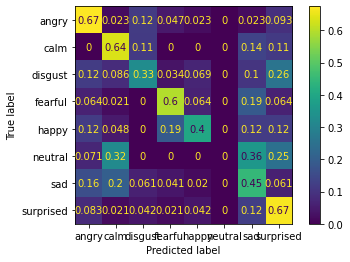

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, x_test_mfcc, y_test_mfcc, normalize = 'true')  
plt.show()

# MLP (mel spectrogram 1d, mean)
- accuracy: 39.4%

In [ ]:
# Initialize the Multi Layer Perceptron Classifier
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
# Train the model
clf = model.fit(x_train_mel1d_mean, y_train_mel1d_mean) # 15sec

In [ ]:
# Predict for the test set
y_pred_mel1d_mean = model.predict(x_test_mel1d_mean)

In [ ]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test_mel1d_mean, y_pred=y_pred_mel1d_mean)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 39.39%


# MLP (mel spectrogram 1d, flatten) 
- accuracy : 38.55%

In [ ]:
# Initialize the Multi Layer Perceptron Classifier
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
# Train the model
clf = model.fit(x_train_mel1d, y_train_mel1d) # 3min 40 sec

In [ ]:
# Predict for the test set
y_pred_mel1d = model.predict(x_test_mel1d)

In [ ]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test_mel1d, y_pred=y_pred_mel1d)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 38.55%


# CNN conv model (mel 2d)
- accuracy 67.04%

In [ ]:
import tensorflow.keras.layers as tfl

In [ ]:
# one hot encode the target 
lb = LabelEncoder()
y_train_mel2d_onehot = np_utils.to_categorical(lb.fit_transform(y_train_mel2d))
y_test_mel2d_onehot = np_utils.to_categorical(lb.fit_transform(y_test_mel2d))

In [ ]:
print(y_train_mel2d_onehot)
print(y_test_mel2d_onehot)
print(y_train_mel2d_onehot.shape)
print(y_test_mel2d_onehot.shape)

In [ ]:
def convolutional_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(8, (4, 4), strides = (1, 1), padding = 'SAME')(input_img)
    ## RELU
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size=(8, 8), strides=8, padding = "SAME")(A1)
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(16, (2, 2), strides = (1, 1), padding = 'SAME')(P1)
    ## RELU
    A2 = tfl.ReLU()(Z2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D((4, 4), (4, 4), padding= 'SAME')(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 8 neurons in output layer. 
    outputs = tfl.Dense(8, activation = 'softmax')(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [ ]:
conv_model = convolutional_model((128, 469, 1)) # input shape(2, 3, 4)
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 469, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 469, 8)       136       
                                                                 
 re_lu (ReLU)                (None, 128, 469, 8)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 59, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 59, 16)        528       
                                                                 
 re_lu_1 (ReLU)              (None, 16, 59, 16)        0         
                                                           

In [ ]:
history = conv_model.fit(x_test_mel2d, y_test_mel2d_onehot, validation_data=(x_test_mel2d, y_test_mel2d_onehot), batch_size = 16, epochs=20)

Epoch 1/20
23/23 [==============================] - 1s 37ms/step - loss: 1.1336 - accuracy: 0.6034 - val_loss: 1.1248 - val_accuracy: 0.5978
Epoch 2/20
23/23 [==============================] - 1s 35ms/step - loss: 1.1220 - accuracy: 0.5978 - val_loss: 1.1130 - val_accuracy: 0.6145
Epoch 3/20
23/23 [==============================] - 1s 33ms/step - loss: 1.1121 - accuracy: 0.6201 - val_loss: 1.1029 - val_accuracy: 0.6285
Epoch 4/20
23/23 [==============================] - 1s 30ms/step - loss: 1.1023 - accuracy: 0.6257 - val_loss: 1.0947 - val_accuracy: 0.6285
Epoch 5/20
23/23 [==============================] - 1s 33ms/step - loss: 1.0941 - accuracy: 0.6313 - val_loss: 1.0869 - val_accuracy: 0.6341
Epoch 6/20
23/23 [==============================] - 1s 29ms/step - loss: 1.0861 - accuracy: 0.6313 - val_loss: 1.0797 - val_accuracy: 0.6313
Epoch 7/20
23/23 [==============================] - 1s 33ms/step - loss: 1.0790 - accuracy: 0.6369 - val_loss: 1.0722 - val_accuracy: 0.6397
Epoch 8/20
23

In [ ]:
temp = conv_model.evaluate(x_test_mel2d, y_test_mel2d_onehot)
# accuracy 67.04

12/12 [==============================] - 0s 15ms/step - loss: 0.9954 - accuracy: 0.6704


# CNN conv model (mfcc 2d)
- accuracy: 63.41%

In [ ]:
# one hot encode the target 
lb = LabelEncoder()
y_train_mfcc2d_onehot = np_utils.to_categorical(lb.fit_transform(y_train_mfcc2d))
y_test_mfcc2d_onehot = np_utils.to_categorical(lb.fit_transform(y_test_mfcc2d))

In [ ]:
# print(y_train_mfcc2d_onehot)
# print(y_test_mfcc2d_onehot)
print(y_train_mfcc2d_onehot.shape)
print(y_test_mfcc2d_onehot.shape)

(1072, 8)
(358, 8)


In [ ]:
conv_model = convolutional_model((x_train_mfcc2d.shape[1], x_train_mfcc2d.shape[2], x_train_mfcc2d.shape[3]))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 282, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 40, 282, 8)        136       
                                                                 
 re_lu (ReLU)                (None, 40, 282, 8)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 36, 8)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 36, 16)         528       
                                                                 
 re_lu_1 (ReLU)              (None, 5, 36, 16)         0         
                                                             

In [ ]:
history = conv_model.fit(x_test_mfcc2d, y_test_mfcc2d_onehot, validation_data=(x_test_mfcc2d, y_test_mfcc2d_onehot), batch_size = 16, epochs=20)

Epoch 1/20
23/23 [==============================] - 13s 39ms/step - loss: 18.6043 - accuracy: 0.1285 - val_loss: 8.9621 - val_accuracy: 0.1676
Epoch 2/20
23/23 [==============================] - 0s 17ms/step - loss: 5.9060 - accuracy: 0.1620 - val_loss: 4.4855 - val_accuracy: 0.2011
Epoch 3/20
23/23 [==============================] - 0s 17ms/step - loss: 3.9778 - accuracy: 0.1927 - val_loss: 3.2965 - val_accuracy: 0.2039
Epoch 4/20
23/23 [==============================] - 0s 16ms/step - loss: 3.1236 - accuracy: 0.2346 - val_loss: 2.8626 - val_accuracy: 0.2542
Epoch 5/20
23/23 [==============================] - 0s 18ms/step - loss: 2.7206 - accuracy: 0.2654 - val_loss: 2.5511 - val_accuracy: 0.2682
Epoch 6/20
23/23 [==============================] - 0s 14ms/step - loss: 2.3820 - accuracy: 0.3017 - val_loss: 2.1831 - val_accuracy: 0.3324
Epoch 7/20
23/23 [==============================] - 0s 14ms/step - loss: 2.1805 - accuracy: 0.2905 - val_loss: 2.1190 - val_accuracy: 0.3659
Epoch 8/20


In [ ]:
temp = conv_model.evaluate(x_test_mfcc2d, y_test_mfcc2d_onehot)

12/12 [==============================] - 0s 7ms/step - loss: 1.0926 - accuracy: 0.6341


# CNN other model (something.. wrong.. debugging)
- accuracy 17.6%

In [ ]:
# emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# y_train_mel2d = np.array(y_train_mel2d)

# for i, emotion in enumerate(emotions_list):
#   y_train_mel2d[y_train_mel2d == emotion] = int(i)

# print(y_train_mel2d)

In [ ]:
# y_train_mel2d = tf.keras.utils.to_categorical(y_train_mel2d, num_classes=8)

In [ ]:
# one hot encode the target 
lb = LabelEncoder()
y_train_mel2d_onehot = np_utils.to_categorical(lb.fit_transform(y_train_mel2d))
y_test_mel2d_onehot = np_utils.to_categorical(lb.fit_transform(y_test_mel2d))

# Normalization as per the standard NN process
# mean = np.mean(x_train_mel2d, axis=0)
# std = np.std(x_train_mel2d, axis=0)

# x_train_mel2d = (x_train_mel2d - mean)/std
# x_test_mel2d = (x_test_mel2d - mean)/std

In [ ]:
print(y_train_mel2d_onehot)
print(y_test_mel2d_onehot)
print(y_train_mel2d_onehot.shape)
print(y_test_mel2d_onehot.shape)

- y_train_mel2d_onehot.shape : (1072, 8)
- y_test_mel2d_onehot.shape: (358, 8)

In [ ]:
# similar to VGG19
def get_2d_conv_model(n):
    ''' Create a standard deep 2D convolutional neural network'''
    nclass = 8
    inp = Input(shape=(n,469,1))  #2D matrix of 30 MFCC bands by 216 audio length.
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dropout(rate=0.2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)
    
    out = Dense(nclass, activation=softmax)(x)
    model = models.Model(inputs=inp, outputs=out)
    
    # opt = optimizers.Adam(0.001)
    opt = tf.keras.optimizers.Adam(0.001)
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [ ]:
model = get_2d_conv_model(n=x_train_mel2d.shape[1])

In [ ]:
model.summary()

In [ ]:
model_history = model.fit(x_train_mel2d, y_train_mel2d_onehot, validation_data=(x_test_mel2d, y_test_mel2d_onehot), batch_size = 16, epochs = 20)
# , batch_size=16, verbose = 2, epochs=20)

Epoch 1/20
67/67 [==============================] - 11s 131ms/step - loss: 2.0657 - acc: 0.1782 - val_loss: 1.9040 - val_acc: 0.2291
Epoch 2/20
67/67 [==============================] - 8s 122ms/step - loss: 1.9888 - acc: 0.2239 - val_loss: 1.9076 - val_acc: 0.2346
Epoch 3/20
67/67 [==============================] - 8s 123ms/step - loss: 1.9643 - acc: 0.2351 - val_loss: 1.9212 - val_acc: 0.2514
Epoch 4/20
67/67 [==============================] - 8s 123ms/step - loss: 1.8902 - acc: 0.2407 - val_loss: 1.9148 - val_acc: 0.2458
Epoch 5/20
67/67 [==============================] - 8s 123ms/step - loss: 1.8928 - acc: 0.2556 - val_loss: 1.9770 - val_acc: 0.2011
Epoch 6/20
67/67 [==============================] - 8s 123ms/step - loss: 1.8628 - acc: 0.2799 - val_loss: 1.9583 - val_acc: 0.2318
Epoch 7/20
67/67 [==============================] - 8s 124ms/step - loss: 1.8461 - acc: 0.2836 - val_loss: 1.9517 - val_acc: 0.2291
Epoch 8/20
67/67 [==============================] - 8s 124ms/step - loss: 1

In [ ]:
model.evaluate(x_test_mel2d, y_test_mel2d_onehot)

12/12 [==============================] - 1s 62ms/step - loss: 2.1608 - acc: 0.1760


[2.1607978343963623, 0.1759776473045349]